Plot Graph

Full DataFrame:
     ImageSize  ScalingFactor       Time                  Mode
0    3500x3500              2  34.572303        Unparallelized
1      300x300              2   0.246977        Unparallelized
2    4000x4000              2  44.422225        Unparallelized
3    3000x3000              2  24.749069        Unparallelized
4    5000x5000              2  69.976608        Unparallelized
..         ...            ...        ...                   ...
195  2800x2800              2   0.896594  ParallelizedByOpenCL
196  2200x2200              2   0.545496  ParallelizedByOpenCL
197  1700x1700              2   0.329986  ParallelizedByOpenCL
198  3200x3200              2   1.162845  ParallelizedByOpenCL
199  2900x2900              2   0.956639  ParallelizedByOpenCL

[200 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

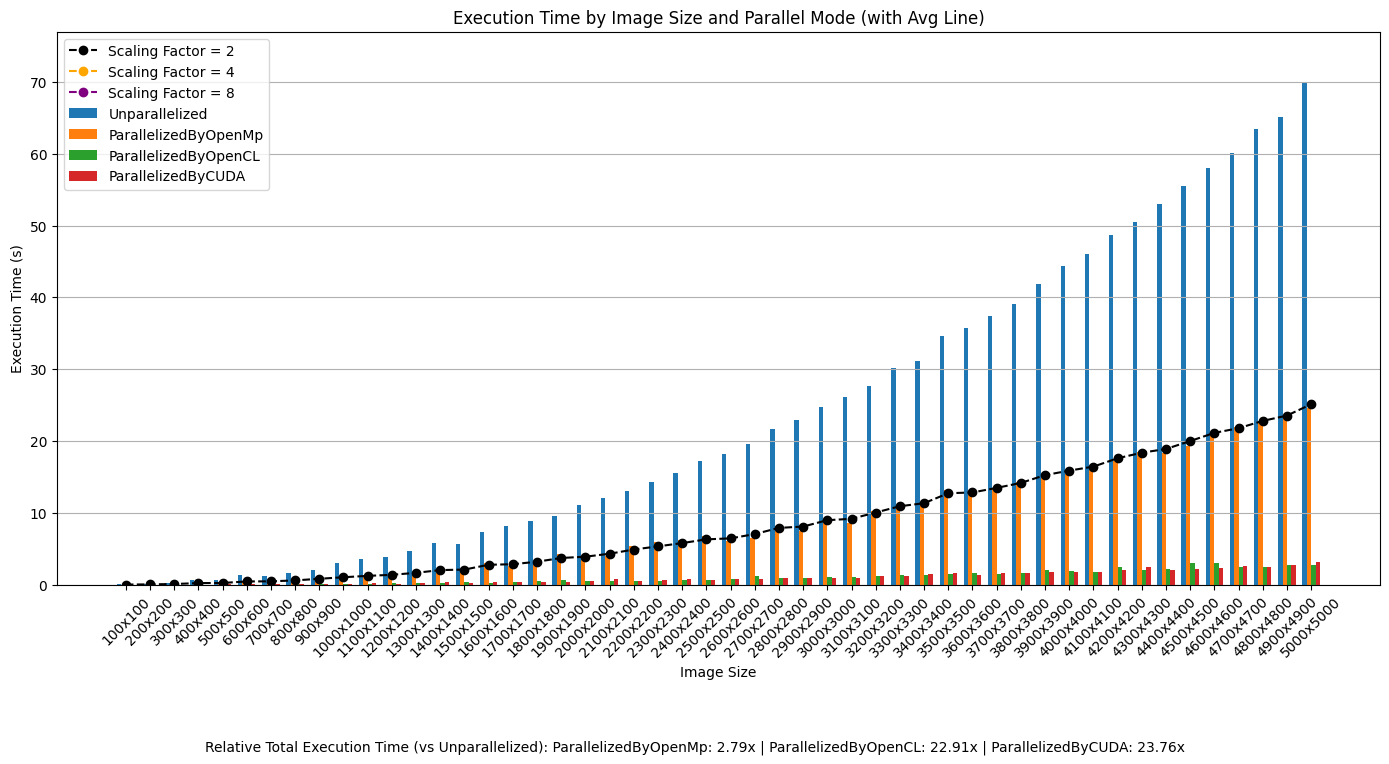

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import os
import re
import numpy as np

# # Upload the CSV file
# uploaded = files.upload()
# uploaded_filename = list(uploaded.keys())[0]
# target_filename = 'scaling_times.csv'

# # Overwrite if needed
# if uploaded_filename != target_filename:
#     with open(uploaded_filename, 'rb') as src, open(target_filename, 'wb') as dst:
#         dst.write(src.read())
#     os.remove(uploaded_filename)
#     print(f"Overwrote {target_filename} with contents from {uploaded_filename}")
# else:
#     print(f"Uploaded file saved as {target_filename}")

# # Load the data
# df = pd.read_csv(target_filename)
# print("Full DataFrame:")
# print(df)

# Specify the file path
file_path = '/content/scaling_time.csv'  # Update with your actual path

# Check if the file exists
if os.path.exists(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    print("Full DataFrame:")
    print(df)
else:
    print(f"Error: File not found at {file_path}")
# Get all unique values
#sort data according the imagesize

def sort_by_size(size_str):
    """Extracts dimensions from a string like '234x432' and returns them as a tuple (width, height)."""
    match = re.match(r'(\d+)x(\d+)', size_str)  # Extract numbers using regex
    if match:
        return int(match.group(1)), int(match.group(2))  # Return width and height
    else:
        return (0, 0)  # Default for invalid format (to prevent errors)


image_sizes = sorted(df['ImageSize'].unique(), key=sort_by_size)

modes = ['Unparallelized', 'ParallelizedByOpenMp', 'ParallelizedByOpenCL', 'ParallelizedByCUDA']
scaling_factors = [2, 4, 8]
mode_colors = ['skyblue', 'lightgreen', 'salmon', 'mediumpurple']
scaling_colors = ['black', 'orange', 'purple']
scaling_labels = ['Scaling Factor = 2', 'Scaling Factor = 4', 'Scaling Factor = 8']

# Prepare bar chart data
bar_data = {mode: [] for mode in modes}
average_times = []

for img_size in image_sizes:
    df_img = df[df['ImageSize'] == img_size]

    # Bar values for each parallel mode
    for mode in modes:
        df_mode = df_img[df_img['Mode'] == mode]
        avg_time = df_mode['Time'].mean() if not df_mode.empty else 0
        bar_data[mode].append(avg_time)

    # Average line value (across all scaling factors & modes)
    avg_total = df_img['Time'].mean() if not df_img.empty else 0
    average_times.append(avg_total)

# Plotting
x = np.arange(len(image_sizes))  # the label locations
bar_width = 0.18
offset_range = np.linspace(-bar_width * 1.5, bar_width * 1.5, len(modes))

plt.figure(figsize=(14, 7))

# Plot bars for each mode
for i, mode in enumerate(modes):
    plt.bar(x + offset_range[i], bar_data[mode], width=bar_width, label=mode)

# Plot line graph for each scaling factor
for sf, color, label in zip(scaling_factors, scaling_colors, scaling_labels):
    sf_means = df[df['ScalingFactor'] == sf].groupby('ImageSize')['Time'].mean().reindex(image_sizes).values
    plt.plot(x + bar_width * 0.0, sf_means, color=color, linestyle='--', marker='o', label=label)


# # Plot average execution line
# plt.plot(x, average_times, color='black', marker='o', linestyle='--', label='Avg Time (All Modes & Scales)')

# Set Y-axis limit to ensure all line points are visible
max_time = max(df['Time'].max(), max([df[df['ScalingFactor'] == sf].groupby('ImageSize')['Time'].mean().max() for sf in scaling_factors]))
plt.ylim(0, max_time * 1.1)  # Add 10% headroom


# Labels and layout
plt.xticks(x, image_sizes, rotation=45)
plt.xlabel('Image Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time by Image Size and Parallel Mode (with Avg Line)')
plt.legend()
plt.grid(True, axis='y')

# --- Compute relative total execution times ---
total_times = df.groupby('Mode')['Time'].sum()

# Ensure all expected modes are present
for mode in modes:
    if mode not in total_times:
        total_times[mode] = 0

unparallel_time = total_times['Unparallelized']
relative_times =  unparallel_time / total_times  # Lower is better (normalized to Unparallelized)

# Format as string to display under chart
relative_info = " | ".join(
    [f"{mode}: {relative_times[mode]:.2f}x" for mode in modes if mode != 'Unparallelized']
)

# Annotate below chart
plt.figtext(0.5, -0.08, f"Relative Total Execution Time (vs Unparallelized): {relative_info}",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

# Save and download
output_file = 'grouped_bar_with_avg_line.png'
plt.savefig(output_file, bbox_inches='tight')
files.download(output_file)

# Show the plot
plt.show()


Show scaling image

In [ ]:
from PIL import Image
import os
from IPython.display import display

def display_images_sorted_by_size(folder_path):
    images_info = []

    try:
        # Gather image info first
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                with Image.open(file_path) as img:
                    width, height = img.size
                    area = width * height
                    images_info.append((area, filename, file_path, width, height))

        # Sort by area (ascending)
        images_info.sort(key=lambda x: x[0])

        # Display sorted images
        for area, filename, file_path, width, height in images_info:
            with Image.open(file_path) as img:
                display(img)
                print(f"Image Name: {filename}")
                print(f"Dimensions: {width} x {height}")
                print("-" * 30)
    except Exception as e:
        print(f"Error: {e}")

# Folder path
folder_path = "/content/output"

# Call the function
display_images_sorted_by_size(folder_path)


Read Image From Drive

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os

# Authenticate
auth.authenticate_user()

drive_service = build('drive', 'v3')

# Specify Folder ID
# https://drive.google.com/drive/folders/1BOvetq0KdxxmrybRnSEiuer1BsRRywF4?usp=drive_link
folder_id = '1BOvetq0KdxxmrybRnSEiuer1BsRRywF4'
query = f"'{folder_id}' in parents and trashed=false"

results = drive_service.files().list(q=query).execute()
files = results.get('files', [])

# Create the directory to save files
os.makedirs('/content/input_images', exist_ok=True)

# Download each file
for file in files:
    request = drive_service.files().get_media(fileId=file['id'])
    file_path = os.path.join('/content/input_images', file['name'])
    with io.FileIO(file_path, 'wb') as file_handle:
        downloader = MediaIoBaseDownload(file_handle, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Downloaded {file['name']} ({status.progress() * 100:.2f}%)")

Downloaded image9.jpg (100.00%)
Downloaded image8.jpg (100.00%)
Downloaded image7.jpg (100.00%)
Downloaded image6.jpg (100.00%)
Downloaded image46.jpg (100.00%)
Downloaded image42.jpg (100.00%)
Downloaded image45.jpg (100.00%)
Downloaded image51.jpg (100.00%)
Downloaded image5.jpg (100.00%)
Downloaded image47.jpg (100.00%)
Downloaded image44.jpg (100.00%)
Downloaded image49.jpg (100.00%)
Downloaded image48.jpg (100.00%)
Downloaded image43.jpg (100.00%)
Downloaded image50.jpg (100.00%)
Downloaded image3.jpg (100.00%)
Downloaded image39.jpg (100.00%)
Downloaded image32.jpg (100.00%)
Downloaded image28.jpg (100.00%)
Downloaded image37.jpg (100.00%)
Downloaded image35.jpg (100.00%)
Downloaded image36.jpg (100.00%)
Downloaded image27.jpg (100.00%)
Downloaded image38.jpg (100.00%)
Downloaded image34.jpg (100.00%)
Downloaded image31.jpg (100.00%)
Downloaded image40.jpg (100.00%)
Downloaded image33.jpg (100.00%)
Downloaded image4.jpg (100.00%)
Downloaded image29.jpg (100.00%)
Downloaded image3

Utilise function header

In [ ]:
%%writefile utilise.h
#ifndef UTILISE_H
#define UTILISE_H

#include <string>
#include <vector>
#include <opencv2/opencv.hpp>

using namespace std; // Allow usage of string, vector, etc. without std::

// Function declarations
unsigned char** createMatrix(int h, int w);
void write_to_csv(const string& filepath, const string& image_size, int scaling_factor, double time, const string& mode);
bool createDirectoryIfNotExists(const string& directory);
bool saveImageWithOpenCV(const string& filename, unsigned char* image, int width, int height);
unsigned char* readImageWithOpenCV(const string& filename, unsigned int& width, unsigned int& height);
unsigned char** getChannel2D(unsigned char* img1D, unsigned int h, unsigned int w, unsigned int index);
unsigned char* convert2Dto1D(unsigned char** img2D, unsigned int h, unsigned int w);
unsigned char* convert2Dto1D(unsigned char** imgR, unsigned char** imgG, unsigned char** imgB, unsigned int h, unsigned int w);
void freeImage2D(unsigned char** mat);
vector<string> getImagesFromDirectory(const string& directory_path);
string getInput(const string& prompt, const string& default_value);
vector<int> getScalingFactors();

#endif // UTILISE_H


Writing utilise.h


Utilise Functions CPP

In [ ]:
%%writefile utilise.cpp
#include "utilise.h"
#include <iostream>
#include <fstream>
#include <cmath>
#include <opencv2/opencv.hpp>
#include <string>
#include <filesystem>
#ifdef _WIN32
#include <windows.h>
#else
#include <dirent.h>
#include <sys/types.h>
#endif

using namespace std;
namespace fs = std::filesystem;
unsigned char** createMatrix(int h, int w) {
    unsigned char** mat;
    int i;
    mat = new unsigned char*[h];
    if (mat == nullptr) return nullptr;
    mat[0] = new unsigned char[h * w];
    if (mat[0] == nullptr) { delete[] mat; return nullptr; }
    for (i = 1; i < h; ++i)
        mat[i] = mat[i - 1] + w;
    return mat;
}

void write_to_csv(const string& filepath, const string& image_size, int scaling_factor, double time, const string& mode) {
    ofstream csv_file;
    bool file_exists = false;

    // Check if file exists
    ifstream check_file(filepath);
    if (check_file.good()) {
        file_exists = true;
    }
    check_file.close();

    if (!file_exists) {
        // Create new file with header
        csv_file.open(filepath);
        if (!csv_file.is_open()) {
            cout << "Error creating CSV file at " << filepath << endl;
            return;
        }
        csv_file << "ImageSize,ScalingFactor,Time,Mode\n";
        csv_file.close();
    }

    // Open in append mode
    csv_file.open(filepath, ios::app);
    if (!csv_file.is_open()) {
        cout << "Error opening CSV file at " << filepath << " in append mode" << endl;
        return;
    }

    // Write data
    csv_file << "\"" << image_size << "\"," << scaling_factor << "," << fixed << setprecision(6) << time << "," << mode << endl;
    csv_file.close();
    cout << "CSV update attempted at: " << filepath << endl;
    ifstream test_csv(filepath);
    if (test_csv) cout << "CSV file is accessible!" << endl;
    else cout << "CSV file could NOT be opened!" << endl;

}

bool createDirectoryIfNotExists(const string& directory) {
    if (!fs::exists(directory)) {
        try {
            fs::create_directories(directory);
        } catch (const fs::filesystem_error& e) {
            cerr << "Error creating directory: " << e.what() << endl;
            return false;
        }
    }
    return true;
}

bool saveImageWithOpenCV(const string& filename, unsigned char* image, int width, int height) {
    // Check if the image pointer is valid
    if (image == nullptr) {
        cerr << "Error: Image data is null!" << endl;
        return false;
    }

    // Convert RGB to BGR before saving (OpenCV default is BGR)
    cv::Mat rgb(height, width, CV_8UC3, image);
    cv::Mat bgr;
    cv::cvtColor(rgb, bgr, cv::COLOR_RGB2BGR);

    // Create the directory if it does not exist
    string directory = filename.substr(0, filename.find_last_of("/"));
    if (!createDirectoryIfNotExists(directory)) {
        return false;
    }

    // Try saving the image
    try {
        if (cv::imwrite(filename, bgr)) {  // ✅ Use the converted BGR image
            cout << "Image saved successfully to: " << filename << endl;
            return true;
        } else {
            cerr << "Failed to save image to: " << filename << endl;
            return false;
        }
    } catch (const cv::Exception& e) {
        cerr << "OpenCV Exception: " << e.what() << endl;
        return false;
    }
}

unsigned char* readImageWithOpenCV(const string& filename, unsigned int& width, unsigned int& height) {
    try {
        // Read image using OpenCV in color
        cv::Mat image = cv::imread(filename, cv::IMREAD_COLOR);
        if (image.empty()) {
            cout << "Error reading image: " << filename << endl;
            return nullptr;
        }

        // Convert from BGR to RGB
        cv::cvtColor(image, image, cv::COLOR_BGR2RGB);

        // Get image dimensions
        height = image.rows;
        width = image.cols;

        // Allocate and copy RGB data
        unsigned char* output = new unsigned char[height * width * 3];
        if (!output) {
            cout << "Memory allocation failed" << endl;
            return nullptr;
        }

        memcpy(output, image.data, height * width * 3);

        return output;
    }
    catch (const cv::Exception& e) {
        cout << "OpenCV error while reading image " << filename << ": " << e.what() << endl;
        return nullptr;
    }
}

unsigned char** getChannel2D(unsigned char* img1D, unsigned int h, unsigned int w, unsigned int index) {
    unsigned char** mat = createMatrix(h, w);
    if (mat == nullptr) return nullptr;

    const unsigned int channels = 3;

    for (unsigned int i = 0; i < h; i++) {
        for (unsigned int j = 0; j < w; j++) {
            unsigned int k = (i * w + j) * channels;
            mat[i][j] = img1D[k + index];
        }
    }
    return mat;
}

unsigned char* convert2Dto1D(unsigned char** img2D, unsigned int h, unsigned int w) {
    unsigned char* img1D = new unsigned char[h * w * 3];
    if (!img1D) return nullptr;

    for (unsigned int i = 0; i < h; i++) {
        unsigned int k = 3 * w * i;
        for (unsigned int j = 0; j < w; j++) {
            unsigned char val = img2D[i][j];
            unsigned int l = 3 * j + k;
            img1D[l] = val;
            img1D[l + 1] = val;
            img1D[l + 2] = val;
        }
    }
    return img1D;
}

unsigned char* convert2Dto1D(unsigned char** imgR, unsigned char** imgG, unsigned char** imgB, unsigned int h, unsigned int w) {
    unsigned char* img1D = new unsigned char[h * w * 3];
    if (!img1D) return nullptr;

    for (unsigned int i = 0; i < h; i++) {
        unsigned int k = 3 * w * i;
        for (unsigned int j = 0; j < w; j++) {
            unsigned int l = 3 * j + k;
            img1D[l] = imgR[i][j];
            img1D[l + 1] = imgG[i][j];
            img1D[l + 2] = imgB[i][j];
        }
    }
    return img1D;
}

void freeImage2D(unsigned char** mat) {
    delete[] mat[0];
    delete[] mat;
}




// Function to get all image files from a directory
vector<string> getImagesFromDirectory(const string& directory_path) {
    vector<string> image_files;
    const vector<string> image_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif"};

#ifdef _WIN32
    // Windows specific code
    WIN32_FIND_DATA file_data;
    HANDLE dir = FindFirstFile((directory_path + "\\*.*").c_str(), &file_data);

    if (dir != INVALID_HANDLE_VALUE) {
        do {
            string filename = file_data.cFileName;
            if (filename != "." && filename != "..") {
                // Convert filename to lowercase for extension checking
                string lower_filename = filename;
                transform(lower_filename.begin(), lower_filename.end(), lower_filename.begin(), ::tolower);

                // Check if file has an image extension
                for (const auto& ext : image_extensions) {
                    if (lower_filename.size() >= ext.size() &&
                        lower_filename.substr(lower_filename.size() - ext.size()) == ext) {
                        image_files.push_back(directory_path + "\\" + filename);
                        break;
                    }
                }
            }
        } while (FindNextFile(dir, &file_data));

        FindClose(dir);
    } else {
        cout << "Could not open directory: " << directory_path << endl;
    }
#else
    // Linux/Unix specific code
    DIR* dir = opendir(directory_path.c_str());

    if (dir != nullptr) {
        struct dirent* entry;
        while ((entry = readdir(dir)) != nullptr) {
            string filename = entry->d_name;
            if (filename != "." && filename != "..") {
                // Convert filename to lowercase for extension checking
                string lower_filename = filename;
                transform(lower_filename.begin(), lower_filename.end(), lower_filename.begin(), ::tolower);

                // Check if file has an image extension
                for (const auto& ext : image_extensions) {
                    if (lower_filename.size() >= ext.size() &&
                        lower_filename.substr(lower_filename.size() - ext.size()) == ext) {
                        image_files.push_back(directory_path + "/" + filename);
                        break;
                    }
                }
            }
        }

        closedir(dir);
    } else {
        cout << "Could not open directory: " << directory_path << endl;
    }
#endif

    return image_files;
}
string getInput(const string& prompt, const string& default_value) {
    string input;
    cout << prompt << " [default: " << default_value << "]: ";
    getline(cin, input);
    if (input.empty()) {
        return default_value;
    }
    return input;
}

// Function to ask user for scaling factors
vector<int> getScalingFactors() {
    vector<int> scaling_factors;
    string input;

    cout << "Enter scaling factors separated by commas (e.g., 2,4,8): ";
    getline(cin, input);

    size_t start = 0;
    size_t end = input.find(",");
    while (end != string::npos) {
        scaling_factors.push_back(stoi(input.substr(start, end - start)));
        start = end + 1;
        end = input.find(",", start);
    }
    scaling_factors.push_back(stoi(input.substr(start)));

    return scaling_factors;
}

Writing utilise.cpp


Serial Code

In [ ]:
%%writefile bicubic.cpp
#include "utilise.h"
#include <iostream>
#include <string>
#include <vector>
#include <filesystem>
#include <iomanip>
#include <omp.h>
#include <string>
using namespace std;
double bicubicpol(double x, double y, double p[4][4]) {
    double a00, a01, a02, a03;
    double a10, a11, a12, a13;
    double a20, a21, a22, a23;
    double a30, a31, a32, a33;
    double x2 = x * x;
    double x3 = x2 * x;
    double y2 = y * y;
    double y3 = y2 * y;

    a00 = p[1][1];
    a01 = -.5 * p[1][0] + .5 * p[1][2];
    a02 = p[1][0] - 2.5 * p[1][1] + 2 * p[1][2] - .5 * p[1][3];
    a03 = -.5 * p[1][0] + 1.5 * p[1][1] - 1.5 * p[1][2] + .5 * p[1][3];
    a10 = -.5 * p[0][1] + .5 * p[2][1];
    a11 = .25 * p[0][0] - .25 * p[0][2] - .25 * p[2][0] + .25 * p[2][2];
    a12 = -.5 * p[0][0] + 1.25 * p[0][1] - p[0][2] + .25 * p[0][3] + .5 * p[2][0] - 1.25 * p[2][1] + p[2][2] - .25 * p[2][3];
    a13 = .25 * p[0][0] - .75 * p[0][1] + .75 * p[0][2] - .25 * p[0][3] - .25 * p[2][0] + .75 * p[2][1] - .75 * p[2][2] + .25 * p[2][3];
    a20 = p[0][1] - 2.5 * p[1][1] + 2 * p[2][1] - .5 * p[3][1];
    a21 = -.5 * p[0][0] + .5 * p[0][2] + 1.25 * p[1][0] - 1.25 * p[1][2] - p[2][0] + p[2][2] + .25 * p[3][0] - .25 * p[3][2];
    a22 = p[0][0] - 2.5 * p[0][1] + 2 * p[0][2] - .5 * p[0][3] - 2.5 * p[1][0] + 6.25 * p[1][1] - 5 * p[1][2] + 1.25 * p[1][3] + 2 * p[2][0] - 5 * p[2][1] + 4 * p[2][2] - p[2][3] - .5 * p[3][0] + 1.25 * p[3][1] - p[3][2] + .25 * p[3][3];
    a23 = -.5 * p[0][0] + 1.5 * p[0][1] - 1.5 * p[0][2] + .5 * p[0][3] + 1.25 * p[1][0] - 3.75 * p[1][1] + 3.75 * p[1][2] - 1.25 * p[1][3] - p[2][0] + 3 * p[2][1] - 3 * p[2][2] + p[2][3] + .25 * p[3][0] - .75 * p[3][1] + .75 * p[3][2] - .25 * p[3][3];
    a30 = -.5 * p[0][1] + 1.5 * p[1][1] - 1.5 * p[2][1] + .5 * p[3][1];
    a31 = .25 * p[0][0] - .25 * p[0][2] - .75 * p[1][0] + .75 * p[1][2] + .75 * p[2][0] - .75 * p[2][2] - .25 * p[3][0] + .25 * p[3][2];
    a32 = -.5 * p[0][0] + 1.25 * p[0][1] - p[0][2] + .25 * p[0][3] + 1.5 * p[1][0] - 3.75 * p[1][1] + 3 * p[1][2] - .75 * p[1][3] - 1.5 * p[2][0] + 3.75 * p[2][1] - 3 * p[2][2] + .75 * p[2][3] + .5 * p[3][0] - 1.25 * p[3][1] + p[3][2] - .25 * p[3][3];
    a33 = .25 * p[0][0] - .75 * p[0][1] + .75 * p[0][2] - .25 * p[0][3] - .75 * p[1][0] + 2.25 * p[1][1] - 2.25 * p[1][2] + .75 * p[1][3] + .75 * p[2][0] - 2.25 * p[2][1] + 2.25 * p[2][2] - .75 * p[2][3] - .25 * p[3][0] + .75 * p[3][1] - .75 * p[3][2] + .25 * p[3][3];

    return (a00 + a01 * y + a02 * y2 + a03 * y3) +
        (a10 + a11 * y + a12 * y2 + a13 * y3) * x +
        (a20 + a21 * y + a22 * y2 + a23 * y3) * x2 +
        (a30 + a31 * y + a32 * y2 + a33 * y3) * x3;
}

unsigned char** imageInterpolate(int f, int h, int w, unsigned char** imgC) {
    double arr[4][4];
    unsigned char** img2g = createMatrix(f * h, f * w);
    if (!img2g) return nullptr;

    for (int i = 0; i < f * h; i++) {
        for (int j = 0; j < f * w; j++) {
            int base_i = i / f;
            int base_j = j / f;
            for (int l = 0; l < 4; l++) {
                for (int k = 0; k < 4; k++) {
                    int ni = base_i + l - 1;
                    int nj = base_j + k - 1;
                    if (ni >= 0 && ni < h && nj >= 0 && nj < w) {
                        arr[l][k] = static_cast<double>(imgC[ni][nj]);
                    }
                    else {
                        arr[l][k] = 0; // Boundary handling
                    }
                }
            }
            double val = bicubicpol(static_cast<double>(i % f) / f, static_cast<double>(j % f) / f, arr);
            img2g[i][j] = static_cast<unsigned char>(val < 0 ? 0 : (val > 255 ? 255 : val));
        }
    }
    return img2g;
}


int main() {
    // Prompt for user input with default values
    string input_directory = getInput("Enter input directory", "input_images");
    string output_directory = getInput("Enter output directory", "output");
    string csv_filepath = getInput("Enter CSV file path", "scaling_time.csv");


    // Get all image files from the directory
    vector<string> image_files = getImagesFromDirectory(input_directory);

    if (image_files.empty()) {
        cout << "No image files found in directory: " << input_directory << endl;
        return 1;
    }

    cout << "Found " << image_files.size() << " image files to process." << endl;

    // Get scaling factors from user
    vector<int> scaling_factors = getScalingFactors();

    // Process each image
    for (const auto& image_path : image_files) {
        // Extract just the filename from the path
        string filename;
        size_t last_slash = image_path.find_last_of("/\\");
        if (last_slash != string::npos) {
            filename = image_path.substr(last_slash + 1);
        } else {
            filename = image_path;
        }

        cout << "\nProcessing image: " << filename << endl;

        unsigned int w = 0, h = 0;
        unsigned char* image1D = readImageWithOpenCV(image_path, w, h);

        if (!image1D) {
            cout << "Failed to load image: " << image_path << endl;
            continue;
        }

        cout << "Dimensions: " << h << " x " << w << endl;
        string image_size = to_string(h) + "x" + to_string(w);

        for (const auto& f : scaling_factors) {
            // Generate output filename
            string output_filename = output_directory + "/";
            size_t dot_pos = filename.find_last_of(".");
            if (dot_pos != string::npos) {
                output_filename += filename.substr(0, dot_pos) + "_" + to_string(f) + "x" + filename.substr(dot_pos);
            } else {
                output_filename += filename + "_" + to_string(f) + "x.png"; // Default to .png if no extension
            }

            double start_time = omp_get_wtime();

            unsigned char** imgR = getChannel2D(image1D, h, w, 0);
            unsigned char** imgG = getChannel2D(image1D, h, w, 1);
            unsigned char** imgB = getChannel2D(image1D, h, w, 2);

            unsigned char** img2gR = imageInterpolate(f, h, w, imgR);
            unsigned char** img2gG = imageInterpolate(f, h, w, imgG);
            unsigned char** img2gB = imageInterpolate(f, h, w, imgB);

            unsigned char* imgRGB1 = convert2Dto1D(img2gR, img2gG, img2gB, f * h, f * w);

            double end_time = omp_get_wtime();
            double time_spent = end_time - start_time;

            // Write to shared CSV file
            write_to_csv(csv_filepath, image_size, f, time_spent, "Unparallelized");
            cout << "Scaling Factor " << f << ", Running time: " << fixed << setprecision(3) << time_spent << " seconds" << endl;

            saveImageWithOpenCV(output_filename, imgRGB1, f * w, f * h); // Use output_filename here

            // Clean up
            freeImage2D(imgR);
            freeImage2D(imgG);
            freeImage2D(imgB);
            freeImage2D(img2gR);
            freeImage2D(img2gG);
            freeImage2D(img2gB);
            delete[] imgRGB1;
        }

        delete[] image1D;
    }

    cout << "\nAll images processed successfully!" << endl;
    return 0;
}

Writing bicubic.cpp


In [ ]:
!g++ bicubic.cpp utilise.cpp -o bicubic `pkg-config --cflags --libs opencv4` -fopenmp -v


Using built-in specs.
COLLECT_GCC=g++
COLLECT_LTO_WRAPPER=/usr/lib/gcc/x86_64-linux-gnu/11/lto-wrapper
OFFLOAD_TARGET_NAMES=nvptx-none:amdgcn-amdhsa
OFFLOAD_TARGET_DEFAULT=1
Target: x86_64-linux-gnu
Configured with: ../src/configure -v --with-pkgversion='Ubuntu 11.4.0-1ubuntu1~22.04' --with-bugurl=file:///usr/share/doc/gcc-11/README.Bugs --enable-languages=c,ada,c++,go,brig,d,fortran,objc,obj-c++,m2 --prefix=/usr --with-gcc-major-version-only --program-suffix=-11 --program-prefix=x86_64-linux-gnu- --enable-shared --enable-linker-build-id --libexecdir=/usr/lib --without-included-gettext --enable-threads=posix --libdir=/usr/lib --enable-nls --enable-bootstrap --enable-clocale=gnu --enable-libstdcxx-debug --enable-libstdcxx-time=yes --with-default-libstdcxx-abi=new --enable-gnu-unique-object --disable-vtable-verify --enable-plugin --enable-default-pie --with-system-zlib --enable-libphobos-checking=release --with-target-system-zlib=auto --enable-objc-gc=auto --enable-multiarch --disable-we

In [ ]:
!./bicubic

Enter input directory [default: input_images]: 
Enter output directory [default: output]: 
Enter CSV file path [default: scaling_time.csv]: 
Found 50 image files to process.
Enter scaling factors separated by commas (e.g., 2,4,8): 2

Processing image: image36.jpg
Dimensions: 3500 x 3500
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 34.572 seconds
Image saved successfully to: output/image36_2x.jpg

Processing image: image4.jpg
Dimensions: 300 x 300
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 0.247 seconds
Image saved successfully to: output/image4_2x.jpg

Processing image: image41.jpg
Dimensions: 4000 x 4000
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 44.422 seconds
Image saved successfully to: output/image41_2x.jpg

Processing image: image31.jpg
Dimensions: 3000 x 3000
CSV update attempted at: scaling_time.csv
CSV file is access

OpenMp Code

In [ ]:
%%writefile OpenMpBicubic.cpp
#include "utilise.h"
#include <iostream>
#include <string>
#include <vector>
#include <filesystem>
#include <iomanip>
#include <omp.h>
#include <string>
using namespace std;

double bicubicpol(double x, double y, double p[4][4]) {
    double x2 = x * x, x3 = x2 * x;
    double y2 = y * y, y3 = y2 * y;
    double cx[4];

    #pragma omp simd
    for (int i = 0; i < 4; i++) {
        double p0 = p[i][0], p1 = p[i][1], p2 = p[i][2], p3 = p[i][3];
        cx[i] = p1 + (-0.5 * p0 + 0.5 * p2) * x +
                (p0 - 2.5 * p1 + 2.0 * p2 - 0.5 * p3) * x2 +
                (-0.5 * p0 + 1.5 * p1 - 1.5 * p2 + 0.5 * p3) * x3;
    }

    double c0 = cx[0], c1 = cx[1], c2 = cx[2], c3 = cx[3];
    return c1 + (-0.5 * c0 + 0.5 * c2) * y +
           (c0 - 2.5 * c1 + 2.0 * c2 - 0.5 * c3) * y2 +
           (-0.5 * c0 + 1.5 * c1 - 1.5 * c2 + 0.5 * c3) * y3;
}

unsigned char** imageInterpolate(int f, int h, int w, unsigned char** imgC) {
    unsigned char** img2g = createMatrix(f * h, f * w);
    if (!img2g) return nullptr;

    const int block_size = 64;
    const double inv_f = 1.0 / f;

    #pragma omp parallel
    {
        double arr[4][4];
        #pragma omp for collapse(2) schedule(dynamic, block_size / 8)
        for (int bi = 0; bi < f * h; bi += block_size) {
            for (int bj = 0; bj < f * w; bj += block_size) {
                int i_max = (bi + block_size < f * h) ? bi + block_size : f * h;
                int j_max = (bj + block_size < f * w) ? bj + block_size : f * w;

                for (int i = bi; i < i_max; i++) {
                    int base_i = i / f;
                    double x = (i % f) * inv_f;

                    int ni[4];
                    for (int l = 0; l < 4; l++) {
                        int idx = base_i + l - 1;
                        ni[l] = (idx < 0) ? 0 : (idx >= h ? h - 1 : idx);
                    }

                    for (int j = bj; j < j_max; j++) {
                        int base_j = j / f;
                        double y = (j % f) * inv_f;

                        if (j == bj || base_j != ((j - 1) / f)) {
                            int nj[4];
                            for (int k = 0; k < 4; k++) {
                                int idx = base_j + k - 1;
                                nj[k] = (idx < 0) ? 0 : (idx >= w ? w - 1 : idx);
                            }
                            #pragma omp simd collapse(2)
                            for (int l = 0; l < 4; l++) {
                                for (int k = 0; k < 4; k++) {
                                    arr[l][k] = (double)imgC[ni[l]][nj[k]];
                                }
                            }
                        }

                        double val = bicubicpol(x, y, arr);
                        img2g[i][j] = (unsigned char)(val < 0 ? 0 : (val > 255 ? 255 : val));
                    }
                }
            }
        }
    }
    return img2g;
}

int main() {
    string input_directory = getInput("Enter input directory", "input_images");
    string output_directory = getInput("Enter output directory", "output");
    string csv_filepath = getInput("Enter CSV file path", "scaling_time.csv");

    vector<string> image_files = getImagesFromDirectory(input_directory);
    if (image_files.empty()) {
        cout << "No image files found in directory: " << input_directory << endl;
        return 1;
    }

    cout << "Found " << image_files.size() << " image files to process." << endl;
    vector<int> scaling_factors = getScalingFactors();

    // Set OpenMP thread count to ensure parallelization
    omp_set_num_threads(omp_get_max_threads());

    for (const auto& image_path : image_files) {
        string filename;
        size_t last_slash = image_path.find_last_of("/\\");
        if (last_slash != string::npos) {
            filename = image_path.substr(last_slash + 1);
        } else {
            filename = image_path;
        }

        cout << "\nProcessing image: " << filename << endl;

        unsigned int w = 0, h = 0;
        unsigned char* image1D = readImageWithOpenCV(image_path, w, h);
        if (!image1D) {
            cout << "Failed to load image: " << image_path << endl;
            continue;
        }

        cout << "Dimensions: " << h << " x " << w << endl;
        string image_size = to_string(h) + "x" + to_string(w);

        for (const auto& f : scaling_factors) {
            string output_filename = output_directory + "/";
            size_t dot_pos = filename.find_last_of(".");
            if (dot_pos != string::npos) {
                output_filename += filename.substr(0, dot_pos) + "_" + to_string(f) + "xOpenMp" + filename.substr(dot_pos);
            } else {
                output_filename += filename + "_" + to_string(f) + "x.png";
            }

            double start_time = omp_get_wtime();

            unsigned char** imgR = getChannel2D(image1D, h, w, 0);
            unsigned char** imgG = getChannel2D(image1D, h, w, 1);
            unsigned char** imgB = getChannel2D(image1D, h, w, 2);

            unsigned char** img2gR = imageInterpolate(f, h, w, imgR);
            unsigned char** img2gG = imageInterpolate(f, h, w, imgG);
            unsigned char** img2gB = imageInterpolate(f, h, w, imgB);

            unsigned char* imgRGB1 = convert2Dto1D(img2gR, img2gG, img2gB, f * h, f * w);
            if (!imgRGB1) {
                cout << "Memory allocation failed for imgRGB1" << endl;
                freeImage2D(imgR);
                freeImage2D(imgG);
                freeImage2D(imgB);
                freeImage2D(img2gR);
                freeImage2D(img2gG);
                freeImage2D(img2gB);
                continue;
            }

            double end_time = omp_get_wtime();
            double time_spent = end_time - start_time;

            write_to_csv(csv_filepath, image_size, f, time_spent, "ParallelizedByOpenMp");
            cout << "Scaling Factor " << f << ", Running time: " << fixed << setprecision(3) << time_spent << " seconds" << endl;

            saveImageWithOpenCV(output_filename, imgRGB1, f * w, f * h);

            freeImage2D(imgR);
            freeImage2D(imgG);
            freeImage2D(imgB);
            freeImage2D(img2gR);
            freeImage2D(img2gG);
            freeImage2D(img2gB);
            delete[] imgRGB1;
        }

        delete[] image1D;
    }

    cout << "\nAll images processed successfully!" << endl;
    return 0;
}

Writing OpenMpBicubic.cpp


In [ ]:
!g++ OpenMpBicubic.cpp utilise.cpp -o OpenMpBicubic `pkg-config --cflags --libs opencv4` -fopenmp -v

Using built-in specs.
COLLECT_GCC=g++
COLLECT_LTO_WRAPPER=/usr/lib/gcc/x86_64-linux-gnu/11/lto-wrapper
OFFLOAD_TARGET_NAMES=nvptx-none:amdgcn-amdhsa
OFFLOAD_TARGET_DEFAULT=1
Target: x86_64-linux-gnu
Configured with: ../src/configure -v --with-pkgversion='Ubuntu 11.4.0-1ubuntu1~22.04' --with-bugurl=file:///usr/share/doc/gcc-11/README.Bugs --enable-languages=c,ada,c++,go,brig,d,fortran,objc,obj-c++,m2 --prefix=/usr --with-gcc-major-version-only --program-suffix=-11 --program-prefix=x86_64-linux-gnu- --enable-shared --enable-linker-build-id --libexecdir=/usr/lib --without-included-gettext --enable-threads=posix --libdir=/usr/lib --enable-nls --enable-bootstrap --enable-clocale=gnu --enable-libstdcxx-debug --enable-libstdcxx-time=yes --with-default-libstdcxx-abi=new --enable-gnu-unique-object --disable-vtable-verify --enable-plugin --enable-default-pie --with-system-zlib --enable-libphobos-checking=release --with-target-system-zlib=auto --enable-objc-gc=auto --enable-multiarch --disable-we

In [ ]:
!./OpenMpBicubic

Enter input directory [default: input_images]: 
Enter output directory [default: output]: 
Enter CSV file path [default: scaling_time.csv]: 
Found 50 image files to process.
Enter scaling factors separated by commas (e.g., 2,4,8): 2

Processing image: image36.jpg
Dimensions: 3500 x 3500
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 13.177 seconds
Image saved successfully to: output/image36_2xOpenMp.jpg

Processing image: image4.jpg
Dimensions: 300 x 300
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 0.080 seconds
Image saved successfully to: output/image4_2xOpenMp.jpg

Processing image: image41.jpg
Dimensions: 4000 x 4000
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 15.434 seconds
Image saved successfully to: output/image41_2xOpenMp.jpg

Processing image: image31.jpg
Dimensions: 3000 x 3000
CSV update attempted at: scaling_time.csv


OpenCL code

In [ ]:
%%writefile OpenCLbicubic.cpp
#include "utilise.h"
#include <iostream>
#include <string>
#include <vector>
#include <filesystem>
#include <iomanip>
#include <omp.h>
#include <string>
#define CL_TARGET_OPENCL_VERSION 300
#ifdef __cplusplus
extern "C" {
#endif

#include <CL/cl.h>

#ifdef __cplusplus
}
#endif

using namespace std;

// OpenCL related variables
cl_context context;
cl_command_queue openclQueue;
cl_program program;
cl_kernel kernel;
cl_int err;

// OpenCL kernel source code with true 2D arrays and optimized bicubicpol
const char* kernelSource = R"(
    // Optimized bicubic interpolation function
    __constant sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP_TO_EDGE | CLK_FILTER_NEAREST;

    double bicubicpol(double x, double y, __local double p[4][4]) {
        double x2 = x * x;
        double x3 = x2 * x;
        double y2 = y * y;
        double y3 = y2 * y;

        // Precompute coefficients for each row
        double row_coeffs[4];
        for (int i = 0; i < 4; i++) {
            double a0 = p[i][1];
            double a1 = -0.5*p[i][0] + 0.5*p[i][2];
            double a2 = p[i][0] - 2.5*p[i][1] + 2*p[i][2] - 0.5*p[i][3];
            double a3 = -0.5*p[i][0] + 1.5*p[i][1] - 1.5*p[i][2] + 0.5*p[i][3];

            row_coeffs[i] = a0 + a1 * y + a2 * y2 + a3 * y3;
        }

        // Combine row results
        double a0 = row_coeffs[1];
        double a1 = -0.5*row_coeffs[0] + 0.5*row_coeffs[2];
        double a2 = row_coeffs[0] - 2.5*row_coeffs[1] + 2*row_coeffs[2] - 0.5*row_coeffs[3];
        double a3 = -0.5*row_coeffs[0] + 1.5*row_coeffs[1] - 1.5*row_coeffs[2] + 0.5*row_coeffs[3];

        return a0 + a1 * x + a2 * x2 + a3 * x3;
    }

    __kernel void imageInterpolate(__global unsigned char* input,
                                  __global unsigned char* output,
                                  const int origHeight,
                                  const int origWidth,
                                  const int scaleFactor,
                                  __local double* localBuffer) {
        // Get global position runs in parallel across multiple work-items (threads).
        int i = get_global_id(0);  // Row
        int j = get_global_id(1);  // Column

        // Get local position
        int localI = get_local_id(0);
        int localJ = get_local_id(1);

        // Define local work size
        int localSizeI = get_local_size(0);
        int localSizeJ = get_local_size(1);

        // Check boundaries
        if (i >= scaleFactor * origHeight || j >= scaleFactor * origWidth) {
            return;
        }

        // Calculate pixel position for bicubic interpolation
        double posY = (double)i / scaleFactor;
        double posX = (double)j / scaleFactor;

        int baseY = (int)posY;
        int baseX = (int)posX;

        // Create a local 2D matrix for the coefficient window
        __local double p[4][4];

        // Fill the coefficient array using local memory
        // Map 1D thread indices to process the 4x4 window in parallel
        int windowI = localI % 4;
        int windowJ = localJ % 4;

        if (windowI < 4 && windowJ < 4) {
            int idxY = baseY + windowI - 1;  // Adjust to center the window
            int idxX = baseX + windowJ - 1;

            // Boundary checking
            if (idxY >= 0 && idxY < origHeight && idxX >= 0 && idxX < origWidth) {
                p[windowI][windowJ] = (double)input[idxY * origWidth + idxX];
            } else {
                // Extend edge values for points outside the image
                int clampedY = idxY < 0 ? 0 : (idxY >= origHeight ? origHeight - 1 : idxY);
                int clampedX = idxX < 0 ? 0 : (idxX >= origWidth ? origWidth - 1 : idxX);
                p[windowI][windowJ] = (double)input[clampedY * origWidth + clampedX];
            }
        }

        // Ensure all threads in the work group have finished loading the coefficients
        barrier(CLK_LOCAL_MEM_FENCE);

        // Only calculate if we're still within valid output bounds
        if (i < scaleFactor * origHeight && j < scaleFactor * origWidth) {
            // Calculate interpolated value
            double fracY = posY - baseY;
            double fracX = posX - baseX;
            double value = bicubicpol(fracX, fracY, p);

            // Clamp value to valid range
            value = clamp(value, 0.0, 255.0);

            // Write output
            output[i * (scaleFactor * origWidth) + j] = (unsigned char)value;
        }
    }
)";

void initOpenCL() {
    cl_uint platformCount = 0;
    cl_int err = clGetPlatformIDs(0, NULL, &platformCount);
    if (err != CL_SUCCESS) {
        printf("Error getting platform count: %d\n", err);
        exit(1);
    }

    if (platformCount == 0) {
        printf("No OpenCL platforms found. Check your installation.\n");
        exit(1);
    }

    printf("Found %d OpenCL platform(s)\n", platformCount);

    // Get first platform
    cl_platform_id platform;
    err = clGetPlatformIDs(1, &platform, NULL);
    if (err != CL_SUCCESS) {
        printf("Error getting platform: %d\n", err);
        exit(1);
    }

    // Get platform name
    char platform_name[256];
    clGetPlatformInfo(platform, CL_PLATFORM_NAME, sizeof(platform_name), platform_name, NULL);
    printf("Using platform: %s\n", platform_name);

    // Get device
    cl_device_id device;
    err = clGetDeviceIDs(platform, CL_DEVICE_TYPE_GPU, 1, &device, NULL);
    if (err != CL_SUCCESS) {
        // If GPU not available, try CPU
        printf("GPU not available, trying CPU...\n");
        err = clGetDeviceIDs(platform, CL_DEVICE_TYPE_CPU, 1, &device, NULL);
        if (err != CL_SUCCESS) {
            printf("Error getting device: %d\n", err);
            exit(1);
        }
    }

    // Get device name
    char device_name[256];
    clGetDeviceInfo(device, CL_DEVICE_NAME, sizeof(device_name), device_name, NULL);
    printf("Using device: %s\n", device_name);

    // Create context
    context = clCreateContext(NULL, 1, &device, NULL, NULL, &err);
    if (err != CL_SUCCESS) {
        printf("Error creating context: %d\n", err);
        exit(1);
    }

    // Create command queue
    cl_command_queue_properties props[] = {CL_QUEUE_PROPERTIES, CL_QUEUE_PROFILING_ENABLE, 0}; // Optional profiling
    openclQueue = clCreateCommandQueueWithProperties(context, device, props, &err);
    if (err != CL_SUCCESS) {
        printf("Error creating command queue: %d\n", err);
        exit(1);
    }

    // Create program
    program = clCreateProgramWithSource(context, 1, &kernelSource, NULL, &err);
    if (err != CL_SUCCESS) {
        printf("Error creating program: %d\n", err);
        exit(1);
    }

    // Build program
    err = clBuildProgram(program, 1, &device, NULL, NULL, NULL);
    if (err != CL_SUCCESS) {
        // Print build log in case of failure
        size_t log_size;
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, 0, NULL, &log_size);
        std::vector<char> log(log_size);
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, log_size, log.data(), NULL);
        std::cerr << "Build log:\n" << log.data() << "\n";
        exit(1);
    }

    // Create kernel
    kernel = clCreateKernel(program, "imageInterpolate", &err);
    if (err != CL_SUCCESS) {
        printf("Error creating kernel: %d\n", err);
        exit(1);
    }
}

void cleanupOpenCL() {
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(openclQueue);
    clReleaseContext(context);
}

unsigned char** imageInterpolateOpenCL(int f, int h, int w, unsigned char** imgC) {
    // Convert 2D array to 1D for OpenCL memory buffer
    unsigned char* input = (unsigned char*)malloc(h * w * sizeof(unsigned char));
    for (int i = 0; i < h; i++) {
        for (int j = 0; j < w; j++) {
            input[i * w + j] = imgC[i][j];
        }
    }

    // Output buffer
    size_t outputSize = f * h * f * w * sizeof(unsigned char);
    unsigned char* output = (unsigned char*)malloc(outputSize);
    memset(output, 0, outputSize); // Initialize to zero

    // Create OpenCL buffers
    cl_mem inputBuffer = clCreateBuffer(context, CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        h * w * sizeof(unsigned char), input, &err);
    if (err != CL_SUCCESS) {
        printf("Error creating input buffer: %d\n", err);
        exit(1);
    }

    cl_mem outputBuffer = clCreateBuffer(context, CL_MEM_WRITE_ONLY,
        outputSize, NULL, &err);
    if (err != CL_SUCCESS) {
        printf("Error creating output buffer: %d\n", err);
        exit(1);
    }

    // Define work group sizes
    size_t localWorkSize[2] = {16, 16}; // Adjust based on your device capabilities
    size_t globalWorkSize[2] = {
        ((f * h + localWorkSize[0] - 1) / localWorkSize[0]) * localWorkSize[0],
        ((f * w + localWorkSize[1] - 1) / localWorkSize[1]) * localWorkSize[1]
    };

    // Calculate the local memory size needed
    size_t localMemSize = 4 * 4 * sizeof(double); // Size of a 4x4 double matrix

    // Set kernel arguments
    clSetKernelArg(kernel, 0, sizeof(cl_mem), &inputBuffer);
    clSetKernelArg(kernel, 1, sizeof(cl_mem), &outputBuffer);
    clSetKernelArg(kernel, 2, sizeof(int), &h);
    clSetKernelArg(kernel, 3, sizeof(int), &w);
    clSetKernelArg(kernel, 4, sizeof(int), &f);
    clSetKernelArg(kernel, 5, localMemSize, NULL); // Local memory buffer

    // Execute kernel
    err = clEnqueueNDRangeKernel(openclQueue, kernel, 2, nullptr, globalWorkSize, localWorkSize, 0, nullptr, nullptr);
    if (err != CL_SUCCESS) {
        printf("Error enqueueing kernel: %d (code %d)\n", err, err);
        exit(1);
    }

    // Wait for kernel to finish
    clFinish(openclQueue);

    // Read results back
    err = clEnqueueReadBuffer(openclQueue, outputBuffer, CL_TRUE, 0,
        outputSize, output, 0, NULL, NULL);
    if (err != CL_SUCCESS) {
        printf("Error reading output buffer: %d\n", err);
        exit(1);
    }

    // Convert 1D array back to 2D
    unsigned char** result = createMatrix(f * h, f * w);
    for (int i = 0; i < f * h; i++) {
        for (int j = 0; j < f * w; j++) {
            result[i][j] = output[i * f * w + j];
        }
    }

    // Cleanup
    clReleaseMemObject(inputBuffer);
    clReleaseMemObject(outputBuffer);
    free(input);
    free(output);

    return result;
}

int main() {
    initOpenCL();

    // Prompt for user input with default values
    string input_directory = getInput("Enter input directory", "input_images");
    string output_directory = getInput("Enter output directory", "output");
    string csv_filepath = getInput("Enter CSV file path", "scaling_time.csv");

    // Create output directory if it doesn't exist
    std::filesystem::create_directories(output_directory);

    // Get all image files from the directory
    vector<string> image_files = getImagesFromDirectory(input_directory);

    if (image_files.empty()) {
        cout << "No image files found in directory: " << input_directory << endl;
        cleanupOpenCL();
        return 1;
    }

    cout << "Found " << image_files.size() << " image files to process." << endl;

    // Get scaling factors from user
    vector<int> scaling_factors = getScalingFactors();

    // Process each image
    for (const auto& image_path : image_files) {
        // Extract just the filename from the path
        string filename;
        size_t last_slash = image_path.find_last_of("/\\");
        if (last_slash != string::npos) {
            filename = image_path.substr(last_slash + 1);
        } else {
            filename = image_path;
        }

        cout << "\nProcessing image: " << filename << endl;

        unsigned int w = 0, h = 0;
        unsigned char* image1D = readImageWithOpenCV(image_path, w, h);

        if (!image1D) {
            cout << "Failed to load image: " << image_path << endl;
            continue;
        }

        cout << "Dimensions: " << h << " x " << w << endl;
        string image_size = to_string(h) + "x" + to_string(w);

        for (const auto& f : scaling_factors) {
            // Generate output filename
            string output_filename = output_directory + "/";
            size_t dot_pos = filename.find_last_of(".");
            if (dot_pos != string::npos) {
                output_filename += filename.substr(0, dot_pos) + "_" + to_string(f) + "xOpenCL" + filename.substr(dot_pos);
            } else {
                output_filename += filename + "_" + to_string(f) + "xOpenCL.png"; // Default to .png if no extension
            }

            double start_time = omp_get_wtime();

            // Process each color channel
            unsigned char** imgR = getChannel2D(image1D, h, w, 0);
            unsigned char** imgG = getChannel2D(image1D, h, w, 1);
            unsigned char** imgB = getChannel2D(image1D, h, w, 2);

            unsigned char** img2gR = imageInterpolateOpenCL(f, h, w, imgR);
            unsigned char** img2gG = imageInterpolateOpenCL(f, h, w, imgG);
            unsigned char** img2gB = imageInterpolateOpenCL(f, h, w, imgB);

            // Combine the channels back to RGB
            unsigned char* imgRGB1 = convert2Dto1D(img2gR, img2gG, img2gB, f * h, f * w);

            double end_time = omp_get_wtime();
            double time_spent = end_time - start_time;

            // Write to shared CSV file
            write_to_csv(csv_filepath, image_size, f, time_spent, "ParallelizedByOpenCL");
            cout << "Scaling Factor " << f << ", Running time: " << fixed << setprecision(3) << time_spent << " seconds" << endl;

            // Save the output image
            saveImageWithOpenCV(output_filename, imgRGB1, f * w, f * h);

            // Clean up
            freeImage2D(imgR);
            freeImage2D(imgG);
            freeImage2D(imgB);
            freeImage2D(img2gR);
            freeImage2D(img2gG);
            freeImage2D(img2gB);
            delete[] imgRGB1;
        }

        delete[] image1D;
    }

    cout << "\nAll images processed successfully!" << endl;
    cleanupOpenCL();
    return 0;
}

Writing OpenCLbicubic.cpp


In [ ]:
!g++ OpenCLbicubic.cpp utilise.cpp -o OpenCLbicubic `pkg-config --cflags --libs opencv4` -lOpenCL -fopenmp -v

Using built-in specs.
COLLECT_GCC=g++
COLLECT_LTO_WRAPPER=/usr/lib/gcc/x86_64-linux-gnu/11/lto-wrapper
OFFLOAD_TARGET_NAMES=nvptx-none:amdgcn-amdhsa
OFFLOAD_TARGET_DEFAULT=1
Target: x86_64-linux-gnu
Configured with: ../src/configure -v --with-pkgversion='Ubuntu 11.4.0-1ubuntu1~22.04' --with-bugurl=file:///usr/share/doc/gcc-11/README.Bugs --enable-languages=c,ada,c++,go,brig,d,fortran,objc,obj-c++,m2 --prefix=/usr --with-gcc-major-version-only --program-suffix=-11 --program-prefix=x86_64-linux-gnu- --enable-shared --enable-linker-build-id --libexecdir=/usr/lib --without-included-gettext --enable-threads=posix --libdir=/usr/lib --enable-nls --enable-bootstrap --enable-clocale=gnu --enable-libstdcxx-debug --enable-libstdcxx-time=yes --with-default-libstdcxx-abi=new --enable-gnu-unique-object --disable-vtable-verify --enable-plugin --enable-default-pie --with-system-zlib --enable-libphobos-checking=release --with-target-system-zlib=auto --enable-objc-gc=auto --enable-multiarch --disable-we

In [ ]:
!./OpenCLbicubic

Found 1 OpenCL platform(s)
Using platform: NVIDIA CUDA
Using device: Tesla T4
Enter input directory [default: input_images]: 
Enter output directory [default: output]: 
Enter CSV file path [default: scaling_time.csv]: 
Found 50 image files to process.
Enter scaling factors separated by commas (e.g., 2,4,8): 2

Processing image: image36.jpg
Dimensions: 3500 x 3500
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 1.546 seconds
Image saved successfully to: output/image36_2xOpenCL.jpg

Processing image: image4.jpg
Dimensions: 300 x 300
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 0.011 seconds
Image saved successfully to: output/image4_2xOpenCL.jpg

Processing image: image41.jpg
Dimensions: 4000 x 4000
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 1.832 seconds
Image saved successfully to: output/image41_2xOpenCL.jpg

Processing image: im

CUDA Code

In [ ]:
%%writefile cuda_bicubic.cu
#include "utilise.h"
#include <iostream>
#include <string>
#include <vector>
#include <filesystem>
#include <iomanip>
#include <omp.h>
#include <string>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

using namespace std;

// CUDA error checking macro
#define CHECK_CUDA_ERROR(err) do { \
    if (err != cudaSuccess) { \
        fprintf(stderr, "CUDA error: %s at %s:%d\n", cudaGetErrorString(err), __FILE__, __LINE__); \
        exit(EXIT_FAILURE); \
    } \
} while(0)

// CUDA kernel for bicubic interpolation
__device__ double bicubicpol(double x, double y, double p[4][4]) {
    double x2 = x * x;
    double x3 = x2 * x;
    double y2 = y * y;
    double y3 = y2 * y;

    // Precompute coefficients for each row
    double row_coeffs[4];
    for (int i = 0; i < 4; i++) {
        double a0 = p[i][1];
        double a1 = -0.5*p[i][0] + 0.5*p[i][2];
        double a2 = p[i][0] - 2.5*p[i][1] + 2*p[i][2] - 0.5*p[i][3];
        double a3 = -0.5*p[i][0] + 1.5*p[i][1] - 1.5*p[i][2] + 0.5*p[i][3];

        row_coeffs[i] = a0 + a1 * y + a2 * y2 + a3 * y3;
    }

    // Combine row results
    double a0 = row_coeffs[1];
    double a1 = -0.5*row_coeffs[0] + 0.5*row_coeffs[2];
    double a2 = row_coeffs[0] - 2.5*row_coeffs[1] + 2*row_coeffs[2] - 0.5*row_coeffs[3];
    double a3 = -0.5*row_coeffs[0] + 1.5*row_coeffs[1] - 1.5*row_coeffs[2] + 0.5*row_coeffs[3];

    return a0 + a1 * x + a2 * x2 + a3 * x3;
}

__global__ void imageInterpolateKernel(unsigned char* input,
                                      unsigned char* output,
                                      const int origHeight,
                                      const int origWidth,
                                      const int scaleFactor) {
    // Get global position
    int i = blockIdx.y * blockDim.y + threadIdx.y;  // Row
    int j = blockIdx.x * blockDim.x + threadIdx.x;  // Column

    // Check boundaries
    if (i >= scaleFactor * origHeight || j >= scaleFactor * origWidth) {
        return;
    }

    // Calculate pixel position for bicubic interpolation
    double posY = (double)i / scaleFactor;
    double posX = (double)j / scaleFactor;

    int baseY = (int)posY;
    int baseX = (int)posX;

    // Create a local 2D matrix for the coefficient window
    double p[4][4];

    // Fill the coefficient array
    for (int windowI = 0; windowI < 4; windowI++) {
        for (int windowJ = 0; windowJ < 4; windowJ++) {
            int idxY = baseY + windowI - 1;  // Adjust to center the window
            int idxX = baseX + windowJ - 1;

            // Boundary checking
            if (idxY >= 0 && idxY < origHeight && idxX >= 0 && idxX < origWidth) {
                p[windowI][windowJ] = (double)input[idxY * origWidth + idxX];
            } else {
                // Extend edge values for points outside the image
                int clampedY = idxY < 0 ? 0 : (idxY >= origHeight ? origHeight - 1 : idxY);
                int clampedX = idxX < 0 ? 0 : (idxX >= origWidth ? origWidth - 1 : idxX);
                p[windowI][windowJ] = (double)input[clampedY * origWidth + clampedX];
            }
        }
    }

    // Calculate interpolated value
    double fracY = posY - baseY;
    double fracX = posX - baseX;
    double value = bicubicpol(fracX, fracY, p);

    // Clamp value to valid range
    value = max(0.0, min(value, 255.0));

    // Write output
    output[i * (scaleFactor * origWidth) + j] = (unsigned char)value;
}

// Function to get CUDA device information
void printCudaDeviceInfo() {
    int deviceCount = 0;
    cudaError_t error = cudaGetDeviceCount(&deviceCount);

    if (error != cudaSuccess) {
        printf("Error getting CUDA device count: %s\n", cudaGetErrorString(error));
        return;
    }

    if (deviceCount == 0) {
        printf("No CUDA-capable devices found.\n");
        return;
    }

    printf("Found %d CUDA device(s)\n", deviceCount);

    for (int i = 0; i < deviceCount; i++) {
        cudaDeviceProp deviceProp;
        cudaGetDeviceProperties(&deviceProp, i);

        printf("Using device %d: %s\n", i, deviceProp.name);
        printf("  Compute capability: %d.%d\n", deviceProp.major, deviceProp.minor);
        printf("  Total global memory: %.2f GB\n",
               static_cast<float>(deviceProp.totalGlobalMem) / (1024.0f * 1024.0f * 1024.0f));
        printf("  Multiprocessors: %d\n", deviceProp.multiProcessorCount);
    }
}

unsigned char** imageInterpolateCUDA(int f, int h, int w, unsigned char** imgC) {
    // Convert 2D array to 1D for CUDA memory buffer
    unsigned char* input = (unsigned char*)malloc(h * w * sizeof(unsigned char));
    for (int i = 0; i < h; i++) {
        for (int j = 0; j < w; j++) {
            input[i * w + j] = imgC[i][j];
        }
    }

    // Output buffer
    size_t outputSize = f * h * f * w * sizeof(unsigned char);
    unsigned char* output = (unsigned char*)malloc(outputSize);
    memset(output, 0, outputSize); // Initialize to zero

    // Create CUDA buffers
    unsigned char *d_input, *d_output;
    CHECK_CUDA_ERROR(cudaMalloc(&d_input, h * w * sizeof(unsigned char)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_output, outputSize));

    // Copy input data to device
    CHECK_CUDA_ERROR(cudaMemcpy(d_input, input, h * w * sizeof(unsigned char), cudaMemcpyHostToDevice));

    // Set up block and grid dimensions
    dim3 blockSize(16, 16);
    dim3 gridSize(
        (f * w + blockSize.x - 1) / blockSize.x,
        (f * h + blockSize.y - 1) / blockSize.y
    );

    // Launch kernel
    imageInterpolateKernel<<<gridSize, blockSize>>>(d_input, d_output, h, w, f);

    // Check for kernel errors
    CHECK_CUDA_ERROR(cudaGetLastError());

    // Wait for kernel to complete
    CHECK_CUDA_ERROR(cudaDeviceSynchronize());

    // Copy results back to host
    CHECK_CUDA_ERROR(cudaMemcpy(output, d_output, outputSize, cudaMemcpyDeviceToHost));

    // Convert 1D array back to 2D
    unsigned char** result = createMatrix(f * h, f * w);
    for (int i = 0; i < f * h; i++) {
        for (int j = 0; j < f * w; j++) {
            result[i][j] = output[i * f * w + j];
        }
    }

    // Cleanup
    cudaFree(d_input);
    cudaFree(d_output);
    free(input);
    free(output);

    return result;
}

int main() {
    // Print CUDA device information
    printCudaDeviceInfo();

    // Prompt for user input with default values
    string input_directory = getInput("Enter input directory", "input_images");
    string output_directory = getInput("Enter output directory", "output");
    string csv_filepath = getInput("Enter CSV file path", "scaling_time.csv");

    // Create output directory if it doesn't exist
    std::filesystem::create_directories(output_directory);

    // Get all image files from the directory
    vector<string> image_files = getImagesFromDirectory(input_directory);

    if (image_files.empty()) {
        cout << "No image files found in directory: " << input_directory << endl;
        return 1;
    }

    cout << "Found " << image_files.size() << " image files to process." << endl;

    // Get scaling factors from user
    vector<int> scaling_factors = getScalingFactors();

    // Process each image
    for (const auto& image_path : image_files) {
        // Extract just the filename from the path
        string filename;
        size_t last_slash = image_path.find_last_of("/\\");
        if (last_slash != string::npos) {
            filename = image_path.substr(last_slash + 1);
        } else {
            filename = image_path;
        }

        cout << "\nProcessing image: " << filename << endl;

        unsigned int w = 0, h = 0;
        unsigned char* image1D = readImageWithOpenCV(image_path, w, h);

        if (!image1D) {
            cout << "Failed to load image: " << image_path << endl;
            continue;
        }

        cout << "Dimensions: " << h << " x " << w << endl;
        string image_size = to_string(h) + "x" + to_string(w);

        for (const auto& f : scaling_factors) {
            // Generate output filename
            string output_filename = output_directory + "/";
            size_t dot_pos = filename.find_last_of(".");
            if (dot_pos != string::npos) {
                output_filename += filename.substr(0, dot_pos) + "_" + to_string(f) + "xCUDA" + filename.substr(dot_pos);
            } else {
                output_filename += filename + "_" + to_string(f) + "xCUDA.png"; // Default to .png if no extension
            }

            double start_time = omp_get_wtime();

            // Process each color channel
            unsigned char** imgR = getChannel2D(image1D, h, w, 0);
            unsigned char** imgG = getChannel2D(image1D, h, w, 1);
            unsigned char** imgB = getChannel2D(image1D, h, w, 2);

            unsigned char** img2gR = imageInterpolateCUDA(f, h, w, imgR);
            unsigned char** img2gG = imageInterpolateCUDA(f, h, w, imgG);
            unsigned char** img2gB = imageInterpolateCUDA(f, h, w, imgB);

            // Combine the channels back to RGB
            unsigned char* imgRGB1 = convert2Dto1D(img2gR, img2gG, img2gB, f * h, f * w);

            double end_time = omp_get_wtime();
            double time_spent = end_time - start_time;

            // Write to shared CSV file
            write_to_csv(csv_filepath, image_size, f, time_spent, "ParallelizedByCUDA");
            cout << "Scaling Factor " << f << ", Running time: " << fixed << setprecision(3) << time_spent << " seconds" << endl;

            // Save the output image
            saveImageWithOpenCV(output_filename, imgRGB1, f * w, f * h);

            // Clean up
            freeImage2D(imgR);
            freeImage2D(imgG);
            freeImage2D(imgB);
            freeImage2D(img2gR);
            freeImage2D(img2gG);
            freeImage2D(img2gB);
            delete[] imgRGB1;
        }

        delete[] image1D;
    }

    cout << "\nAll images processed successfully!" << endl;
    return 0;
}

Writing cuda_bicubic.cu


In [ ]:
!nvcc -c cuda_bicubic.cu -o cuda_bicubic.o `pkg-config --cflags opencv4` -arch=sm_75

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
!g++ -c utilise.cpp -o utilise.o -fopenmp `pkg-config --cflags opencv4`

In [ ]:
!g++ cuda_bicubic.o utilise.o -o cuda_bicubic -fopenmp `pkg-config --libs opencv4` -L/usr/local/cuda/lib64 -lcudart

In [ ]:
!./cuda_bicubic

Found 1 CUDA device(s)
Using device 0: Tesla T4
  Compute capability: 7.5
  Total global memory: 14.74 GB
  Multiprocessors: 40
Enter input directory [default: input_images]: 
Enter output directory [default: output]: 
Enter CSV file path [default: scaling_time.csv]: 
Found 50 image files to process.
Enter scaling factors separated by commas (e.g., 2,4,8): 2

Processing image: image51.jpg
Dimensions: 5000 x 5000
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 3.481 seconds
Image saved successfully to: output/image51_2xCUDA.jpg

Processing image: image43.jpg
Dimensions: 4200 x 4200
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 1.940 seconds
Image saved successfully to: output/image43_2xCUDA.jpg

Processing image: image29.jpg
Dimensions: 2800 x 2800
CSV update attempted at: scaling_time.csv
CSV file is accessible!
Scaling Factor 2, Running time: 0.849 seconds
Image saved successfully to:

In [ ]:
!sudo apt update
!sudo apt purge nvidia -y
!sudo apt install nvidia-driver-530 -y

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,118 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,844 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Get:13 http://archive.ubun